<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_75-25/blob/main/2024_Revnb_75_25_Update_H2_T6_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 904.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 777.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 702.4 kB/s eta 0:00:00


In [2]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [3]:
# Fix random seed for reproducibility
tf.random.set_seed(10)
plt.rcParams['figure.figsize'] = (12,6)

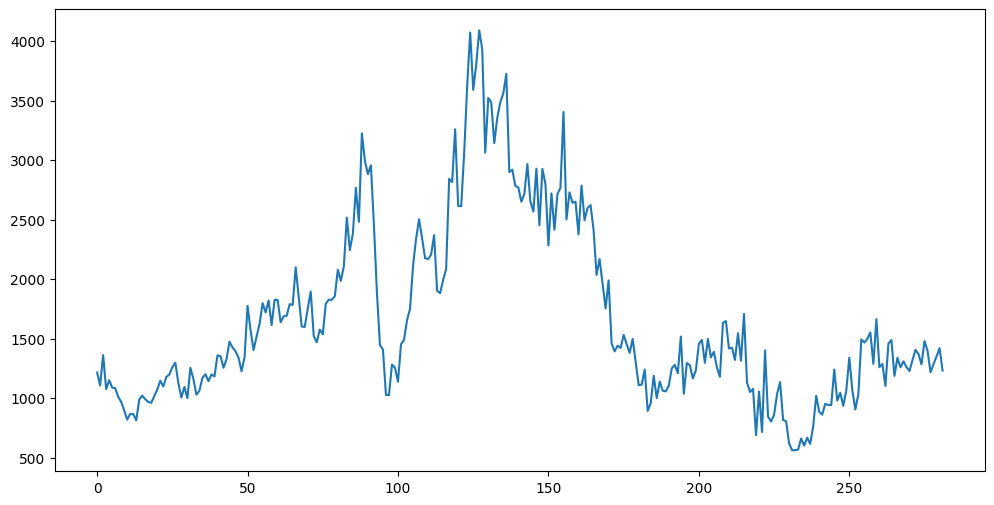

In [4]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Peramalan-LSTM_75-25/main/Ekspor-Migas-2001-2024.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')
plt.plot(dataset)

In [5]:
# Pembagian data
#train_size = int(len(dataset)*0.75)
train_size = 211
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [6]:
time_steps = 6
last_row_train = train[-time_steps:]
test = np.concatenate([last_row_train, test], axis=0)

In [7]:
ytest = test
ytrain = train

In [8]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit(dataset)

train = scaled_data.transform(train)
test = scaled_data.transform(test)

In [9]:
# Fungsi untuk membuat dataset
def create_dataset (X, y, time_steps = time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
X_test, y_test = create_dataset(test, test)
X_train, y_train = create_dataset(train, train)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (205, 6, 1)
y_train.shape:  (205, 1)
X_test.shape:  (71, 6, 1)
y_test.shape:  (71, 1)


In [11]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [13]:
def objective(trial):
    # Define the search space
    lstm_units_1 = trial.suggest_categorical('lstm_units_1', [32, 64, 128])
    lstm_units_2 = trial.suggest_categorical('lstm_units_2', [32, 64, 128])
    dropout_rate_1 = trial.suggest_categorical('dropout_rate_1', [0.1, 0.2, 0.3, 0.4, 0.5])
    dropout_rate_2 = trial.suggest_categorical('dropout_rate_2', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for fold_index, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model with 2 hidden layers
        model = Sequential([
            LSTM(units=lstm_units_1, return_sequences=True, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate_1),
            LSTM(units=lstm_units_2),
            Dropout(dropout_rate_2),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

        # Print MSE for each fold
        print(f"Fold {fold_index + 1}: MSE = {mse:.4f}")

    # Print average MSE across all folds
    print(f"Average MSE: {np.mean(cv_scores):.4f}")

    return np.mean(cv_scores)

In [14]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-15 07:34:17,543] A new study created in memory with name: no-name-4abe3d42-9295-4bbd-8e45-d851aca783f9


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Fold 1: MSE = 0.0192
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 2: MSE = 0.0386


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
Fold 3: MSE = 0.0626
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 4: MSE = 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2024-08-15 07:34:52,406] Trial 0 finished with value: 0.02637127973139286 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.02637127973139286.


Fold 5: MSE = 0.0029
Average MSE: 0.0264
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step
Fold 1: MSE = 0.0269
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step
Fold 2: MSE = 0.0415
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step
Fold 3: MSE = 0.0196
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
Fold 4: MSE = 0.0064
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2024-08-15 07:35:30,710] Trial 1 finished with value: 0.019335733726620674 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.019335733726620674.


Fold 5: MSE = 0.0022
Average MSE: 0.0193
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 1: MSE = 0.0249
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Fold 2: MSE = 0.7270
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 3: MSE = 0.2245
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 4: MSE = 0.0498
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2024-08-15 07:36:03,360] Trial 2 finished with value: 0.8516613245010376 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.019335733726620674.


Fold 5: MSE = 3.2321
Average MSE: 0.8517
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
Fold 1: MSE = 2.3450
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step
Fold 2: MSE = 0.8807
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 3: MSE = 8.2635
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
Fold 4: MSE = 19.5084
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2024-08-15 07:36:40,122] Trial 3 finished with value: 6.248195171356201 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.019335733726620674.


Fold 5: MSE = 0.2434
Average MSE: 6.2482
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 460ms/step
Fold 1: MSE = 0.0847
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
Fold 2: MSE = 0.1660
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 470ms/step
Fold 3: MSE = 0.4563
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 4: MSE = 0.2085
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step


[I 2024-08-15 07:37:10,089] Trial 4 finished with value: 0.18675260245800018 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.2, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.019335733726620674.


Fold 5: MSE = 0.0181
Average MSE: 0.1868
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Fold 1: MSE = 0.0295
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step
Fold 2: MSE = 0.0441
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 3: MSE = 0.0361
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 442ms/step
Fold 4: MSE = 0.0202
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


[I 2024-08-15 07:37:45,539] Trial 5 finished with value: 0.027679434046149254 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.019335733726620674.


Fold 5: MSE = 0.0084
Average MSE: 0.0277
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
Fold 1: MSE = 0.0373
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
Fold 2: MSE = 0.0442
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
Fold 3: MSE = 0.1226
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
Fold 4: MSE = 0.0069
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2024-08-15 07:38:21,237] Trial 6 finished with value: 0.04264422506093979 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.019335733726620674.


Fold 5: MSE = 0.0023
Average MSE: 0.0426
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
Fold 1: MSE = 0.0446
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
Fold 2: MSE = 0.0871
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
Fold 3: MSE = 0.2810
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step
Fold 4: MSE = 0.0452
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step


[I 2024-08-15 07:38:50,514] Trial 7 finished with value: 0.09671101719141006 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.019335733726620674.


Fold 5: MSE = 0.0255
Average MSE: 0.0967
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
Fold 1: MSE = 0.0036
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
Fold 2: MSE = 2.5287
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 3: MSE = 3.5803
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step
Fold 4: MSE = 1.7757
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step


[I 2024-08-15 07:39:27,778] Trial 8 finished with value: 1.8851416110992432 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.019335733726620674.


Fold 5: MSE = 1.5374
Average MSE: 1.8851
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step
Fold 1: MSE = 0.1370
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
Fold 2: MSE = 0.0826
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
Fold 3: MSE = 0.1889
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 440ms/step
Fold 4: MSE = 0.0235
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


[I 2024-08-15 07:40:07,075] Trial 9 finished with value: 0.08851577341556549 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.5, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.019335733726620674.


Fold 5: MSE = 0.0107
Average MSE: 0.0885
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
Fold 1: MSE = 0.0192
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 2: MSE = 0.0231
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 3: MSE = 0.1048
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
Fold 4: MSE = 0.0082
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2024-08-15 07:40:42,718] Trial 10 finished with value: 0.03168382868170738 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.019335733726620674.


Fold 5: MSE = 0.0030
Average MSE: 0.0317
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
Fold 1: MSE = 0.0091
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 2: MSE = 0.0257
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 3: MSE = 0.0262
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
Fold 4: MSE = 0.0136
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2024-08-15 07:41:15,816] Trial 11 finished with value: 0.015794500708580017 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.015794500708580017.


Fold 5: MSE = 0.0044
Average MSE: 0.0158
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
Fold 1: MSE = 0.0104
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 2: MSE = 0.0250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Fold 3: MSE = 0.0262
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
Fold 4: MSE = 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2024-08-15 07:41:46,861] Trial 12 finished with value: 0.01721760630607605 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.015794500708580017.


Fold 5: MSE = 0.0078
Average MSE: 0.0172
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
Fold 1: MSE = 0.0084
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 2: MSE = 0.0260
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 3: MSE = 0.0478
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 4: MSE = 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2024-08-15 07:42:19,487] Trial 13 finished with value: 0.020210299640893936 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.015794500708580017.


Fold 5: MSE = 0.0046
Average MSE: 0.0202
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 1: MSE = 0.0081
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 2: MSE = 0.0250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 3: MSE = 0.0235
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 4: MSE = 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


[I 2024-08-15 07:42:50,876] Trial 14 finished with value: 0.015545216389000416 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.015545216389000416.


Fold 5: MSE = 0.0044
Average MSE: 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
Fold 1: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
Fold 2: MSE = 0.0249
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
Fold 3: MSE = 0.0315
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
Fold 4: MSE = 0.0166
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


[I 2024-08-15 07:43:20,671] Trial 15 finished with value: 0.017150988802313805 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.015545216389000416.


Fold 5: MSE = 0.0040
Average MSE: 0.0172
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
Fold 1: MSE = 0.0081
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Fold 2: MSE = 0.0452
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
Fold 3: MSE = 0.0640
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
Fold 4: MSE = 0.0090
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2024-08-15 07:43:55,332] Trial 16 finished with value: 0.026640310883522034 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.4, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.015545216389000416.


Fold 5: MSE = 0.0069
Average MSE: 0.0266
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Fold 1: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
Fold 2: MSE = 0.0258
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Fold 3: MSE = 0.0491
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 4: MSE = 0.0146
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2024-08-15 07:44:25,836] Trial 17 finished with value: 0.021867919713258743 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.015545216389000416.


Fold 5: MSE = 0.0111
Average MSE: 0.0219
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 460ms/step
Fold 1: MSE = 0.0769
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
Fold 2: MSE = 0.2130
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
Fold 3: MSE = 0.3886
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 4: MSE = 0.2141
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2024-08-15 07:44:48,254] Trial 18 finished with value: 0.18237175047397614 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 14 with value: 0.015545216389000416.


Fold 5: MSE = 0.0193
Average MSE: 0.1824
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
Fold 1: MSE = 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
Fold 2: MSE = 0.0487
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Fold 3: MSE = 0.0756
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 4: MSE = 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2024-08-15 07:45:22,946] Trial 19 finished with value: 0.030305320397019386 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.015545216389000416.


Fold 5: MSE = 0.0098
Average MSE: 0.0303
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
Fold 1: MSE = 0.0075
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
Fold 2: MSE = 0.0262
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 3: MSE = 0.0247
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
Fold 4: MSE = 0.0132
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2024-08-15 07:45:54,311] Trial 20 finished with value: 0.015288455411791801 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0048
Average MSE: 0.0153
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
Fold 1: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
Fold 2: MSE = 0.0273
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 3: MSE = 0.0307
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
Fold 4: MSE = 0.0122
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2024-08-15 07:46:25,136] Trial 21 finished with value: 0.01680823788046837 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0052
Average MSE: 0.0168
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
Fold 1: MSE = 0.0085
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
Fold 2: MSE = 0.0257
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 3: MSE = 0.0500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step
Fold 4: MSE = 0.0159
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2024-08-15 07:46:54,690] Trial 22 finished with value: 0.02085856720805168 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0042
Average MSE: 0.0209
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step
Fold 1: MSE = 0.0078
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
Fold 2: MSE = 0.0245
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
Fold 3: MSE = 0.0630
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
Fold 4: MSE = 0.0144
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


[I 2024-08-15 07:47:31,339] Trial 23 finished with value: 0.023137271404266357 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0061
Average MSE: 0.0231
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
Fold 1: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 2: MSE = 0.0249
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 3: MSE = 0.0237
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Fold 4: MSE = 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2024-08-15 07:48:01,244] Trial 24 finished with value: 0.015485579147934914 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0052
Average MSE: 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step
Fold 1: MSE = 0.0878
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Fold 2: MSE = 0.1523
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
Fold 3: MSE = 0.4665
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
Fold 4: MSE = 0.1725
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


[I 2024-08-15 07:48:23,103] Trial 25 finished with value: 0.17858245968818665 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0139
Average MSE: 0.1786
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
Fold 1: MSE = 0.0129
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Fold 2: MSE = 0.0259
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Fold 3: MSE = 0.0277
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
Fold 4: MSE = 0.0101
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2024-08-15 07:48:53,785] Trial 26 finished with value: 0.016503211110830307 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0059
Average MSE: 0.0165
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 1: MSE = 0.0201
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
Fold 2: MSE = 0.0280
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 3: MSE = 0.1447
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
Fold 4: MSE = 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


[I 2024-08-15 07:49:26,182] Trial 27 finished with value: 0.04315358027815819 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0061
Average MSE: 0.0432
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
Fold 1: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
Fold 2: MSE = 0.0525
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 3: MSE = 0.0679
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2024-08-15 07:50:04,236] Trial 28 finished with value: 0.029559317976236343 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0100
Average MSE: 0.0296
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 1: MSE = 0.0234
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step
Fold 2: MSE = 0.0718
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 3: MSE = 0.1042
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
Fold 4: MSE = 0.0108
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step


[I 2024-08-15 07:50:28,638] Trial 29 finished with value: 0.04312194511294365 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.4, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0054
Average MSE: 0.0431
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 1: MSE = 0.0163
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 442ms/step
Fold 2: MSE = 0.0367
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
Fold 3: MSE = 0.0396
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step
Fold 4: MSE = 0.0089
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2024-08-15 07:50:59,116] Trial 30 finished with value: 0.021946456283330917 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.3, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0083
Average MSE: 0.0219
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step
Fold 1: MSE = 0.0085
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
Fold 2: MSE = 0.0284
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
Fold 3: MSE = 0.0413
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 4: MSE = 0.0191
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


[I 2024-08-15 07:51:29,154] Trial 31 finished with value: 0.02054370567202568 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0055
Average MSE: 0.0205
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 1: MSE = 0.0092
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
Fold 2: MSE = 0.0362
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
Fold 3: MSE = 0.0435
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
Fold 4: MSE = 0.0208
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2024-08-15 07:51:59,880] Trial 32 finished with value: 0.022950682789087296 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0052
Average MSE: 0.0230
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
Fold 1: MSE = 0.0069
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step
Fold 2: MSE = 0.0246
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
Fold 3: MSE = 0.0348
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
Fold 4: MSE = 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2024-08-15 07:52:36,929] Trial 33 finished with value: 0.017853135243058205 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0074
Average MSE: 0.0179
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
Fold 1: MSE = 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
Fold 2: MSE = 0.0287
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 3: MSE = 0.0230
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 4: MSE = 0.0148
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2024-08-15 07:53:06,821] Trial 34 finished with value: 0.016502132639288902 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0063
Average MSE: 0.0165
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 1: MSE = 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 2: MSE = 0.0255
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
Fold 3: MSE = 0.0506
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 4: MSE = 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


[I 2024-08-15 07:53:37,927] Trial 35 finished with value: 0.021453222259879112 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.0074
Average MSE: 0.0215
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 1: MSE = 0.0448
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step
Fold 2: MSE = 0.1081
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 3: MSE = 0.2087
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
Fold 4: MSE = 0.0488
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


[I 2024-08-15 07:54:05,020] Trial 36 finished with value: 0.10806147009134293 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.2, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.015288455411791801.


Fold 5: MSE = 0.1300
Average MSE: 0.1081
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Fold 1: MSE = 0.0210
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
Fold 2: MSE = 0.0227
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 3: MSE = 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 4: MSE = 0.0083
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step


[I 2024-08-15 07:54:40,857] Trial 37 finished with value: 0.014172191731631756 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 37 with value: 0.014172191731631756.


Fold 5: MSE = 0.0021
Average MSE: 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
Fold 1: MSE = 0.0257
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
Fold 2: MSE = 0.0677
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
Fold 3: MSE = 0.0287
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step
Fold 4: MSE = 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2024-08-15 07:55:15,020] Trial 38 finished with value: 0.030423179268836975 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 37 with value: 0.014172191731631756.


Fold 5: MSE = 0.0177
Average MSE: 0.0304
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step
Fold 1: MSE = 0.0443
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 440ms/step
Fold 2: MSE = 0.0841
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
Fold 3: MSE = 0.2272
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
Fold 4: MSE = 0.0394
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2024-08-15 07:55:50,917] Trial 39 finished with value: 0.08605390042066574 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 37 with value: 0.014172191731631756.


Fold 5: MSE = 0.0353
Average MSE: 0.0861
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Fold 1: MSE = 0.0248
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
Fold 2: MSE = 0.0250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step
Fold 3: MSE = 0.0353
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 4: MSE = 0.0079
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2024-08-15 07:56:28,950] Trial 40 finished with value: 0.019053617492318153 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 37 with value: 0.014172191731631756.


Fold 5: MSE = 0.0023
Average MSE: 0.0191
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 1: MSE = 0.0231
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 2: MSE = 0.0239
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step
Fold 3: MSE = 0.0153
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
Fold 4: MSE = 0.0058
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


[I 2024-08-15 07:57:05,949] Trial 41 finished with value: 0.014098463580012321 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 41 with value: 0.014098463580012321.


Fold 5: MSE = 0.0023
Average MSE: 0.0141
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
Fold 1: MSE = 0.0189
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 2: MSE = 0.0272
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 3: MSE = 0.0220
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Fold 4: MSE = 0.0061
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step


[I 2024-08-15 07:57:42,348] Trial 42 finished with value: 0.015271447598934174 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 41 with value: 0.014098463580012321.


Fold 5: MSE = 0.0021
Average MSE: 0.0153
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
Fold 1: MSE = 0.0255
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step
Fold 2: MSE = 0.0231
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Fold 3: MSE = 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
Fold 4: MSE = 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2024-08-15 07:58:18,514] Trial 43 finished with value: 0.01423698104918003 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 41 with value: 0.014098463580012321.


Fold 5: MSE = 0.0026
Average MSE: 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
Fold 1: MSE = 0.0239
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 2: MSE = 0.0599
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
Fold 3: MSE = 0.0264
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 4: MSE = 0.0075
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2024-08-15 07:58:53,116] Trial 44 finished with value: 0.025194913148880005 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 41 with value: 0.014098463580012321.


Fold 5: MSE = 0.0082
Average MSE: 0.0252
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step
Fold 1: MSE = 0.0181
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 2: MSE = 0.0221
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step
Fold 3: MSE = 0.0177
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
Fold 4: MSE = 0.0061
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2024-08-15 07:59:29,832] Trial 45 finished with value: 0.013456953689455986 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 45 with value: 0.013456953689455986.


Fold 5: MSE = 0.0033
Average MSE: 0.0135
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
Fold 1: MSE = 0.0266
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step
Fold 2: MSE = 0.0232
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
Fold 3: MSE = 0.0135
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
Fold 4: MSE = 0.0073
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2024-08-15 08:00:15,784] Trial 46 finished with value: 0.014666050672531128 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 45 with value: 0.013456953689455986.


Fold 5: MSE = 0.0027
Average MSE: 0.0147
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step
Fold 1: MSE = 0.0171
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
Fold 2: MSE = 0.0226
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
Fold 3: MSE = 0.0340
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
Fold 4: MSE = 0.0078
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


[I 2024-08-15 08:00:54,881] Trial 47 finished with value: 0.016790112480521202 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 45 with value: 0.013456953689455986.


Fold 5: MSE = 0.0024
Average MSE: 0.0168
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
Fold 1: MSE = 0.0199
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step
Fold 2: MSE = 0.0207
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
Fold 3: MSE = 0.0154
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
Fold 4: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2024-08-15 08:01:33,524] Trial 48 finished with value: 0.012957786209881306 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 48 with value: 0.012957786209881306.


Fold 5: MSE = 0.0026
Average MSE: 0.0130
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 1: MSE = 0.0217
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
Fold 2: MSE = 0.0787
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 3: MSE = 0.0290
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 449ms/step
Fold 4: MSE = 0.0138
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2024-08-15 08:02:09,193] Trial 49 finished with value: 0.029150735586881638 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 48 with value: 0.012957786209881306.


Fold 5: MSE = 0.0026
Average MSE: 0.0292
Best parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}
Best value: 0.012957786209881306


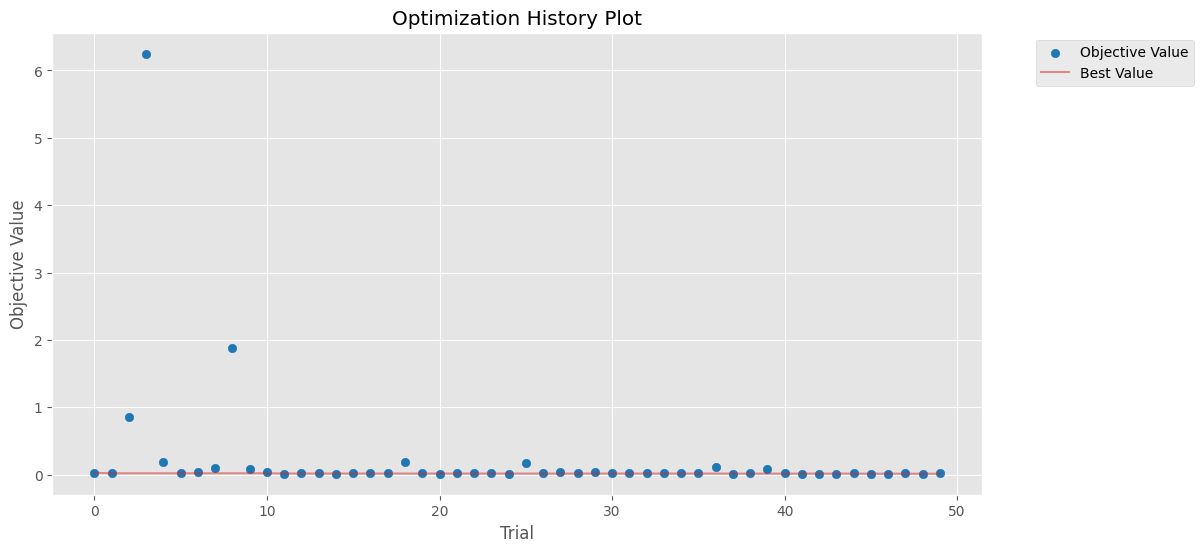

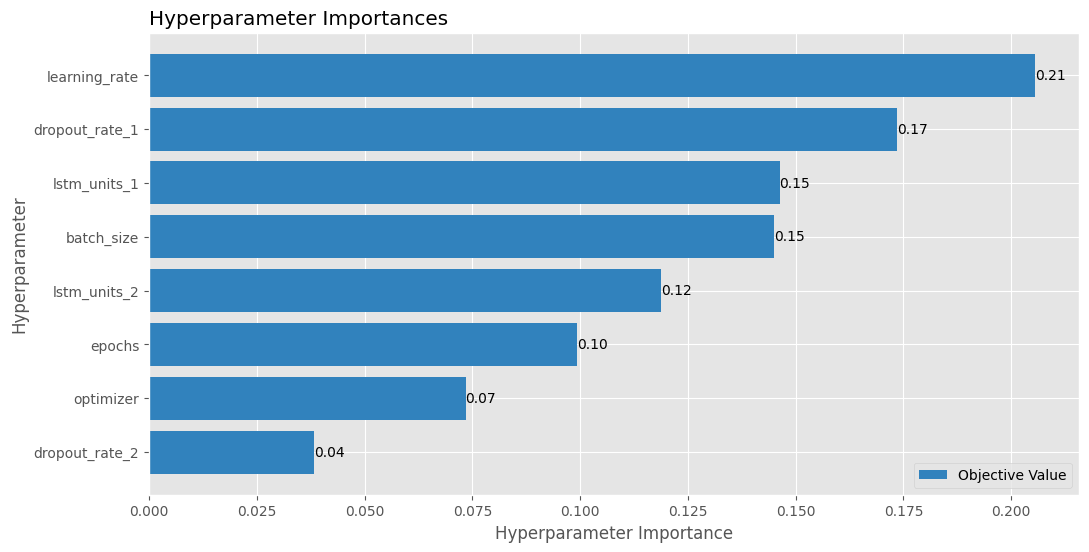

In [15]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [16]:
# Train final model with best parameters
best_params = study.best_params
model =  Sequential([
    LSTM(units=best_params['lstm_units_1'], return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate_1']),
    LSTM(units=best_params['lstm_units_2']),
    Dropout(best_params['dropout_rate_2']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - loss: 0.1441 - val_loss: 0.1101
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1128 - val_loss: 0.0114
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0699 - val_loss: 0.0285
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0322 - val_loss: 0.0290
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0245 - val_loss: 0.0022
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0299 - val_loss: 0.0052
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0200 - val_loss: 0.0210
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0216 - val_loss: 0.0033
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0156 - val_loss: 0.0040
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0125 - val_loss: 0.0091
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0162 - val_loss: 0.0040
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0153 - val_loss: 0.0026


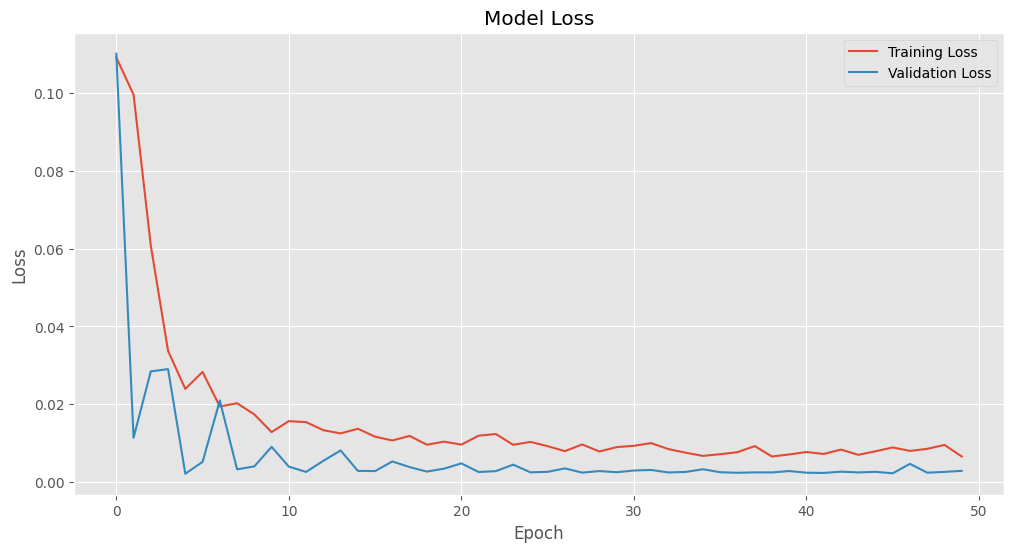

Average Loss: 0.0162


In [17]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [18]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [19]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [21]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 183.449
Root Mean Square Error: 250.551
Mean Absolute Percentage Error: 10.082%

evaluasi model data test:
Mean Absolute Error: 166.291
Root Mean Square Error: 209.149
Mean Absolute Percentage Error: 15.804%



In [22]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

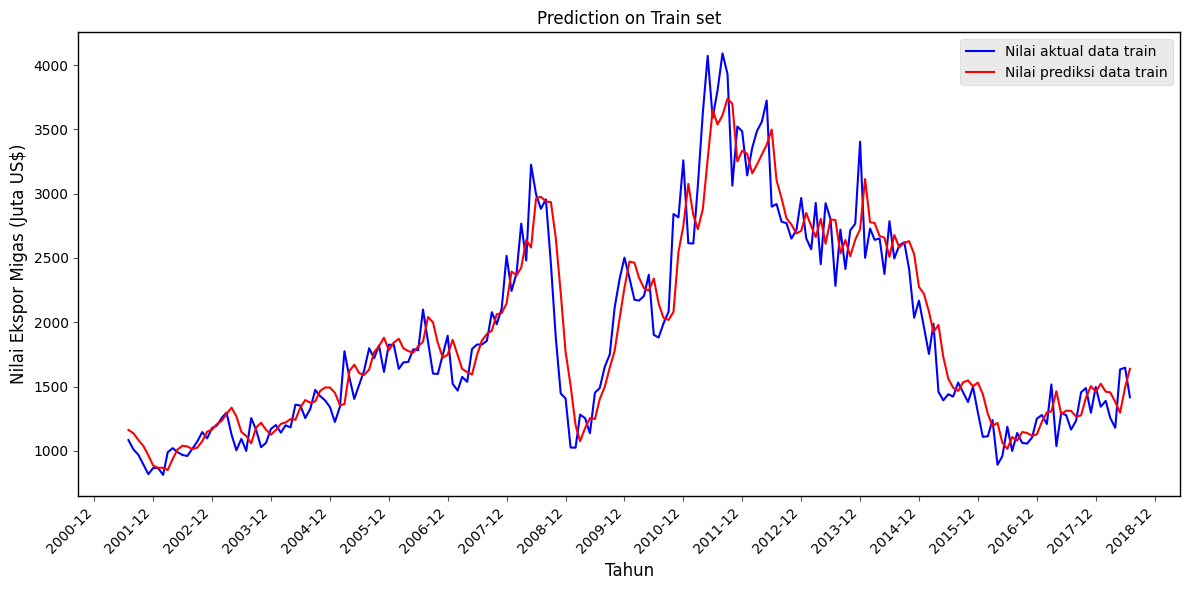

In [23]:
import matplotlib.dates as mdates
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

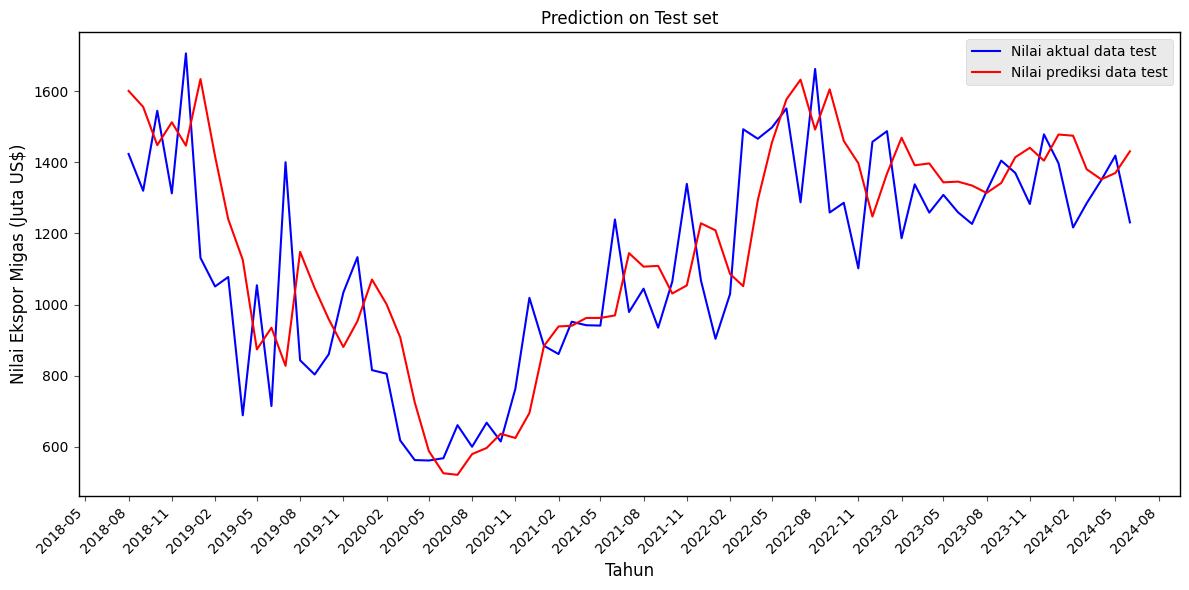

In [24]:
# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

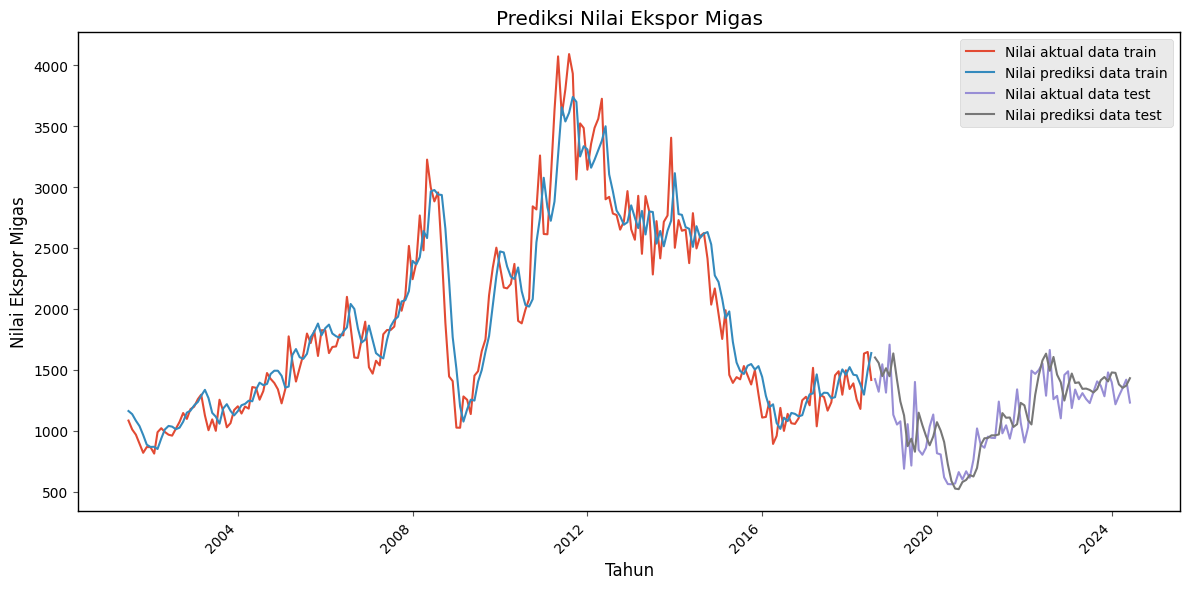

In [25]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-07-01                     1375.825195
1  2024-08-01                     1412.496826
2  2024-09-01                     1443.388794
3  2024-10-01                     1488.646484
4  2024-11-01                     1539.681152
5  2024-12-01                     1592.842773
6  2025-01-01                     1641.776001
7  2025-02-01                     1694.568726
8  2025-03-01                     1748.091919
9  2025-04-01                     1801.470581
10 2025-05-01                     1854

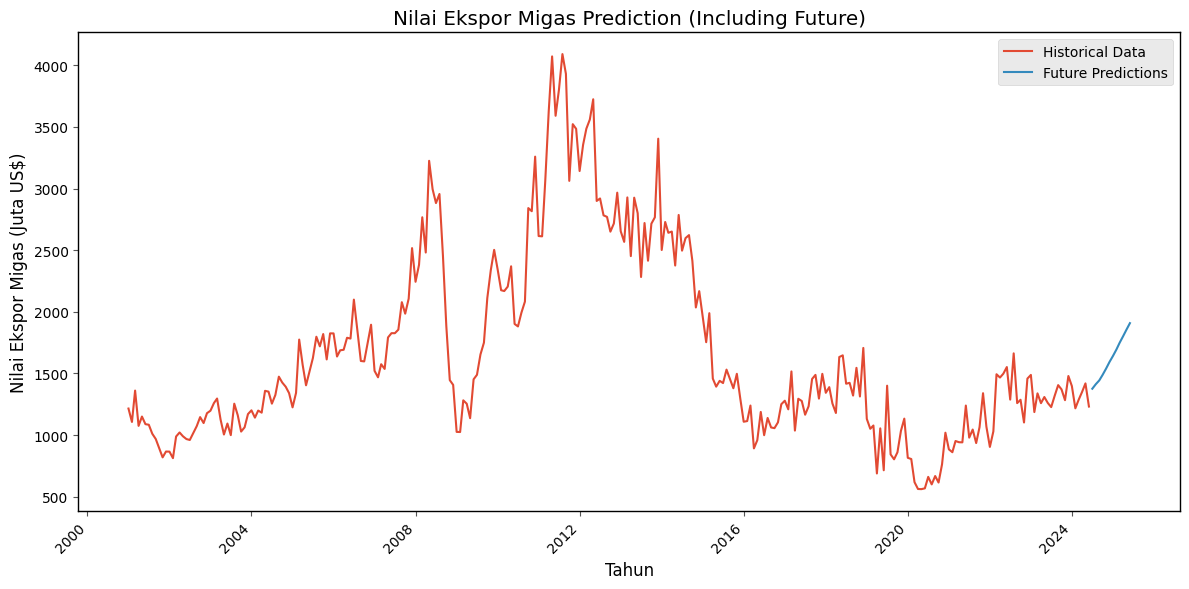

In [26]:
scaled_dt = scaler.fit_transform(dataset)

# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_dt[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()


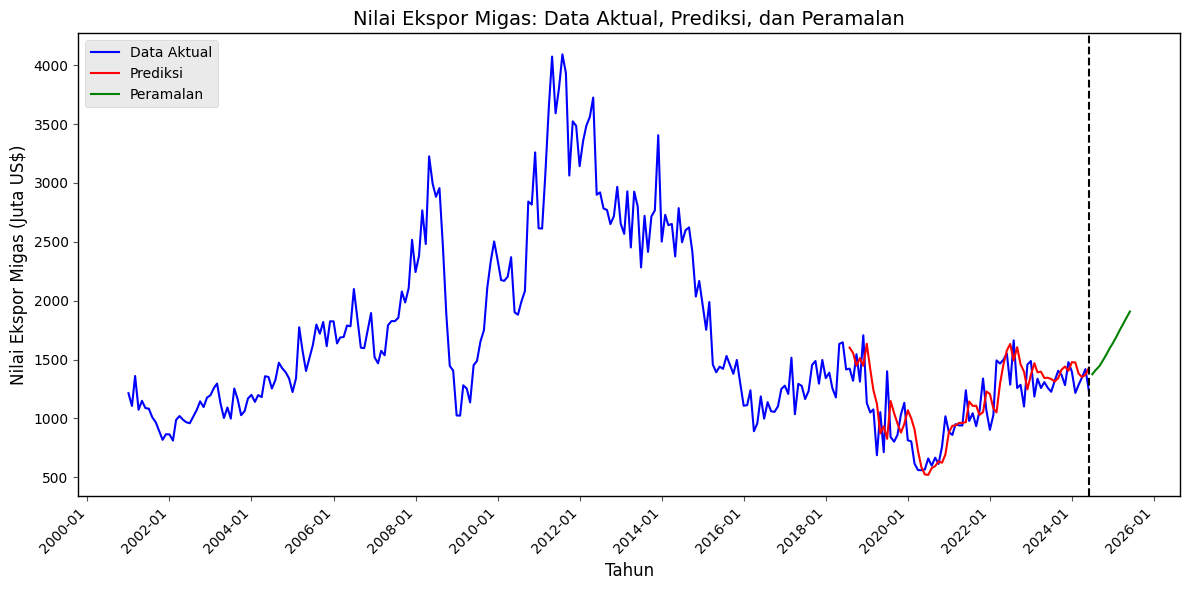

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [28]:
!pip install openpyxl

In [29]:
forecast_df.to_excel('forecast_2024-75:25_h2t6.xlsx', index=False)
from google.colab import files
files.download('forecast_2024-75:25_h2t6.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_2024-75:25_h2t6.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_2024-75:25_h2t6.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>